# Training M-RCNN on COCO annotation files

The annotation files were generated in the K-Fold python notebook

# Installing Detectron and Importing Libraries

In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vzj2pg0t
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vzj2pg0t
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9176db667837c57e7118d92a90f887565bd6d4c1
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 106 kB 1.2 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 49 kB 1.9 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 968 kB/s            
     |████████████████████████████████| 145 kB 2.5 MB/s            
     |████████████████████████████████| 130 kB 3.7 MB/s            
     |████████████████████████████████| 112 kB 4.0 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86

In [2]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator

from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

import warnings

warnings.filterwarnings("ignore")
setup_logger()


<_Logger detectron2 (DEBUG)>

# Load the competition data

The COCO dataset was generated using the K-Fold python notebook. The code block below loads all the images containing astro cells which is then used for training our Mask R-CNN.

To train the model using other classes or for one of the 5 folds, use the corresponding annotation files as listed below:

1. cort - cort_train.json and cort_val.json
2. shsy5y - shsy5y_train.json and shsy5y_val.json
3. Fold 1 - train_fold_1.json and train_fold_1.json
4. Fold 2 - train_fold_2.json and train_fold_2.json
5. Fold 3 - train_fold_3.json and train_fold_3.json
6. Fold 4 - train_fold_4.json and train_fold_4.json
7. Fold 5 - train_fold_5.json and train_fold_5.json

In [3]:
dataDir = Path("../input/sartorius-cell-instance-segmentation/")
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT = "bitmask"
register_coco_instances(
    "sartorius_train", {}, "../input/livecellcoco/astro_train.json", dataDir
)
register_coco_instances(
    "sartorius_val", {}, "../input/livecellcoco/astro_val.json", dataDir
)
metadata = MetadataCatalog.get("sartorius_train")
train_ds = DatasetCatalog.get("sartorius_train")


WARNING [12/15 01:36:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/15 01:36:12 d2.data.datasets.coco]: Loaded 104 images in COCO format from ../input/livecellcoco/astro_train.json


# Display a sample file to check the data is loaded correctly

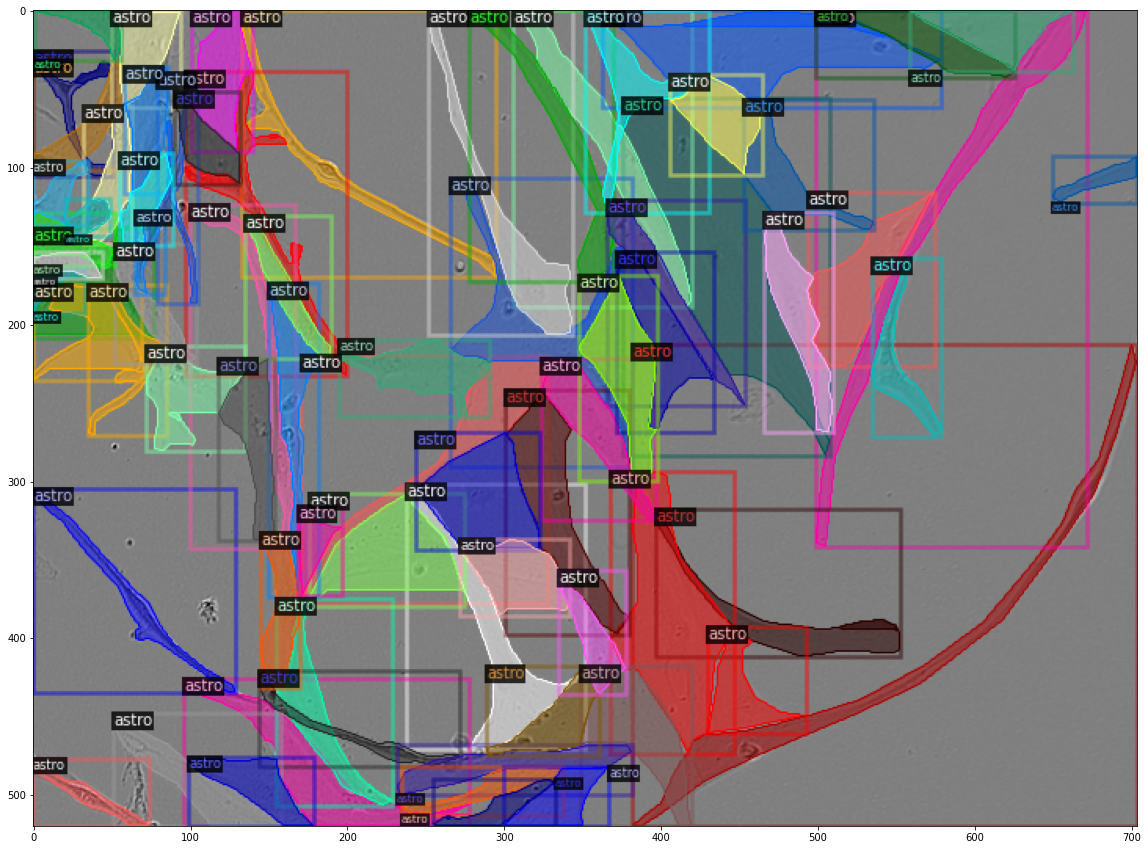

In [4]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize=(20, 15))
plt.imshow(out.get_image()[:, :, ::-1])


# Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [5]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  
    false_positives = np.sum(matches, axis=0) == 0  
    false_negatives = np.sum(matches, axis=1) == 0
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)


def score(pred, targ):
    pred_masks = pred["instances"].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order="F")) for p in pred_masks]
    enc_targs = list(map(lambda x: x["segmentation"], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0] * len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05): # competition metric
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)


class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {
            item["image_id"]: item["annotations"] for item in dataset_dicts
        }

    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out["instances"]) == 0:
                self.scores.append(0)
            else:
                targ = self.annotations_cache[inp["image_id"]]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}


class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):
        cfg = self.cfg.clone()
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            BestCheckpointer(
                cfg.TEST.EVAL_PERIOD,
                DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                "MaP IoU",
                "max",
            ),
        )
        return hooks


# Train
We use the default hyperparameters from the detectron tutorial. 

Training for 100 iterations here for demonstration. For a high scoring model we trained for 10000 iterations.

In [6]:
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.EVAL_PERIOD = (
    len(DatasetCatalog.get("sartorius_train")) // cfg.SOLVER.IMS_PER_BATCH
)  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


WARNING [12/15 01:36:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/15 01:36:15 d2.data.datasets.coco]: Loaded 104 images in COCO format from ../input/livecellcoco/astro_train.json
[12/15 01:36:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelM

model_final_f10217.pkl: 178MB [00:02, 59.6MB/s]                           


[12/15 01:36:28 d2.engine.train_loop]: Starting training from iteration 0
[12/15 01:36:54 d2.utils.events]:  eta: 0:01:14  iter: 19  total_loss: 3.003  loss_cls: 0.6487  loss_box_reg: 0.6304  loss_mask: 0.6835  loss_rpn_cls: 0.77  loss_rpn_loc: 0.2874  time: 1.0005  data_time: 0.5766  lr: 9.5405e-05  max_mem: 3688M
[12/15 01:37:11 d2.utils.events]:  eta: 0:00:54  iter: 39  total_loss: 2.334  loss_cls: 0.5518  loss_box_reg: 0.7462  loss_mask: 0.5651  loss_rpn_cls: 0.229  loss_rpn_loc: 0.2683  time: 0.9265  data_time: 0.4762  lr: 0.00019531  max_mem: 3688M
WARNING [12/15 01:37:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/15 01:37:25 d2.data.datasets.coco]: Loaded 27 images in COCO format from ../input/livecellcoco/astro_val.json
[12/15 01:37:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   astro    | 1901         |
|            | 

# Lets look at some of the predicted masks
We show predictions on the left and ground truth on the right.

WARNING [12/15 01:38:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/15 01:38:22 d2.data.datasets.coco]: Loaded 27 images in COCO format from ../input/livecellcoco/astro_val.json


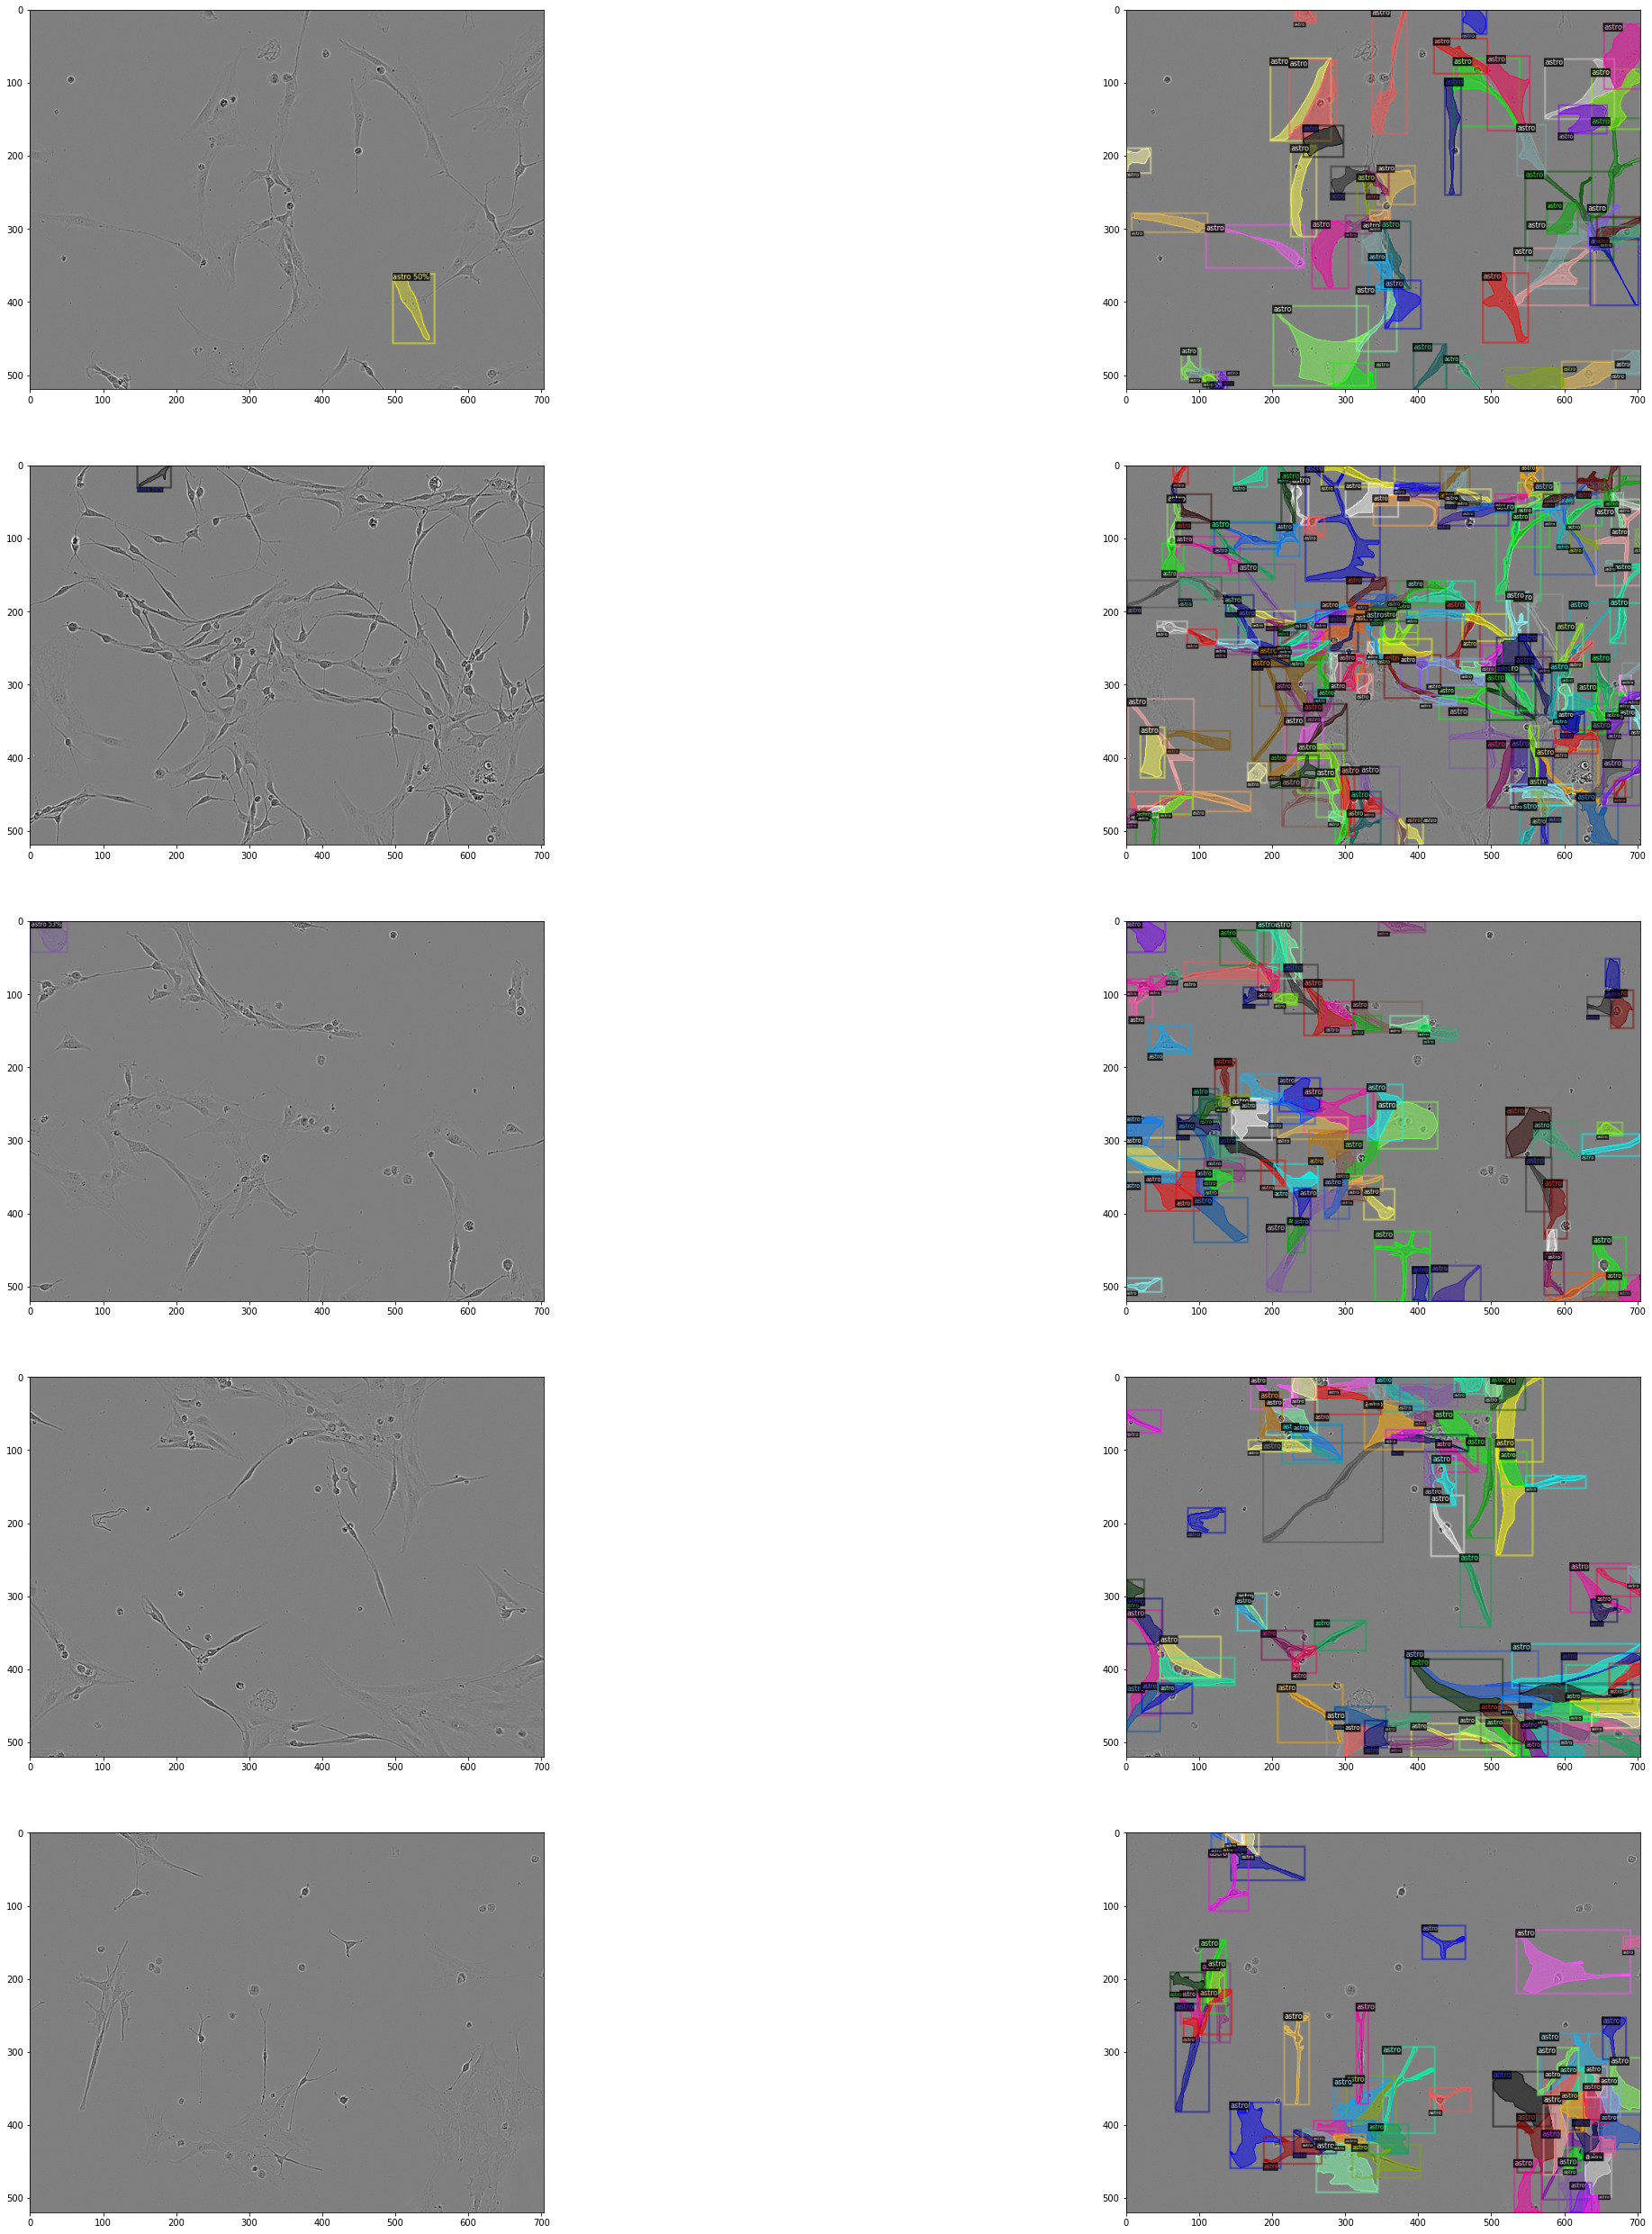

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(
    cfg.OUTPUT_DIR, "model_best.pth"
)  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get("sartorius_val")
outs = []
for d in random.sample(dataset_dicts, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    v = Visualizer(
        im[:, :, ::-1],
        metadata=MetadataCatalog.get("sartorius_train"),
        instance_mode=ColorMode.IMAGE_BW,
    )

    out_pred = v.draw_instance_predictions(outputs["instances"].to('cpu'))
    visualizer = Visualizer(
        im[:, :, ::-1], metadata=MetadataCatalog.get("sartorius_train")
    )
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)

_, axs = plt.subplots(len(outs) // 2, 2, figsize=(40, 45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])
